# A first DMFT calculation

The goal of this notebook is to make a first DMFT calculation using the iterated perturbation theory (IPT) to solve the impurity problem.
You will proceed in two steps: first you will set up the IPT
impurity solver and then you will set up the DMFT loop.

## The iterated perturbation theory

The IPT is a cheap way to solve the impurity problem at half-filling, but fails away from half-filling [(further information)](https://doi.org/10.1103/PhysRevB.86.085133). It **approximates** the self-energy by second-order
perturbation theory, just like in the last exercise of the notebook
on Green's functions:

$$ \Sigma(i\omega_n) = \frac{U}{2} + U^2 \int_0^\beta d\tau e^{i \omega_n \tau} {\cal G}_0(\tau)^3 $$

Note that the first term, $\frac{U}{2}$, is the chemical potential $\mu$ for half-filling.

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 1

An impurity solver takes a non-interacting Green's function $G_0$, an impurity interaction $U$ and an inverse temperature $\beta$ as an input and returns the interacting Green's function $G$ as well as the
self-energy $\Sigma$.

Write a function that takes $U$, $\beta$ and ${\cal G}_0(i\omega)$ as an input and returns the second order perturbation theory result for $\Sigma(i\omega)$ as well as the corresponding $G(i\omega)$. 
If you are more familiar with python, you can write a `Solver` class that is constructed with $\beta$.
The class should contain a class member `G0` that is to be initialized by the user.
It should further contain a member function `solve` that, given the interaction $U$, sets the class members $G$ and $\Sigma$ to the results. 
The advantage of using a class is that Green's functions will not have to be constructed at every call of the
function `solve`.

For half-filling $\mu$ corresponds to $U/2$ for the one band model discussed here. It is however common practice to shift both the self-energy and $\mu$ by $-U/2$ (keeping $G$ unchanged). This way $\mu=0$ corresponds to the half-filled case, and the self-energy only consists of the second term in the IPT equation.

In [1]:
from triqs.gf import *
import numpy as np
from math import pi
class IPTSolver:
    def __init__(self, beta):
        self.beta = beta

        # Matsubara frequency Green's functions
        iw_mesh = MeshImFreq(beta=beta, S='Fermion', n_iw=1001)
        self.G_iw = Gf(mesh=iw_mesh, target_shape=[1,1])
        self.G0_iw = self.G_iw.copy() # self.G0 will be set by the user after initialization
        self.Sigma_iw = self.G_iw.copy()
        
        # Imaginary time
        tau_mesh = MeshImTime(beta=beta, S='Fermion', n_tau=10001)
        self.G0_tau = Gf(mesh=tau_mesh, target_shape=[1,1])
        self.Sigma_tau = self.G0_tau.copy()
        
    def solve(self, U):
        self.G0_tau << Fourier(self.G0_iw)
        self.Sigma_tau << (U**2) * self.G0_tau * self.G0_tau * self.G0_tau
        self.Sigma_iw << Fourier(self.Sigma_tau)
        
        # Dyson
        self.G_iw << inverse(inverse(self.G0_iw) - self.Sigma_iw)

## Dynamical mean-field theory

In DMFT, the lattice self-energy is approximated by that of an impurity
model. One has to recursively solve a model in order to satisfy the
self-consistency relation

$$ G_\mathrm{imp} = \sum_k \frac{1}{i \omega_n + \mu - \epsilon_k - \Sigma_\mathrm{imp}} $$

In practice one starts with a chosen ${\cal G}_0$ and then solves the quantum
impurity problem. This yields $\Sigma_\mathrm{imp}$. Using the self-consistency
relation and Dyson's equation, we have a new proposal for ${\cal G}_0$:

$$ \Big( {\cal G}_0^\mathrm{new} \Big)^{-1} =
\Big( \sum_k \frac{1}{i \omega_n + \mu - \epsilon_k - \Sigma_\mathrm{imp}} \Big)^{-1}
+ \Sigma_\mathrm{imp} $$

We solve the quantum impurity for this new $G_0$ and loop until
convergence

<img src="imgs/selfcons.png" width=40%>


## Bethe lattice DMFT

When the lattice is a Bethe lattice with infinite coordination, the self-consistency relation
discussed above takes a particularly simple form

$$ {\cal G}_0^{-1} = i\omega_n + \mu - t^2 G_\mathrm{imp} $$

Hence, we do not need to perform a $k$-sum over the Brillouin zone to extract the new Weiss field ${\cal G}_0$ for the Bethe lattice. Note that this is a specific attribute of the Bethe lattice, and for other lattice types one has to use the Dyson equation.

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 2

You will now implement the DMFT loop for the Bethe lattice using the IPT solver that you have
defined above. We give you the beginning of the script so that you have the parameters.
In order to see how the DMFT loops converge, plot the spectral function of the Green's function
at every loop. Use the Pade approximation to obtain the real-frequency Green's function.

Note that, as we chose the convention $\mu=0$ for the IPT solver, the chemical potential also drops out of the self-consistency relation of the Bethe lattice.

Remember that the non-interacting Green's function ${\cal G}_0(i\omega)$ for the Bethe lattice can be obtained using `SemiCircular`.

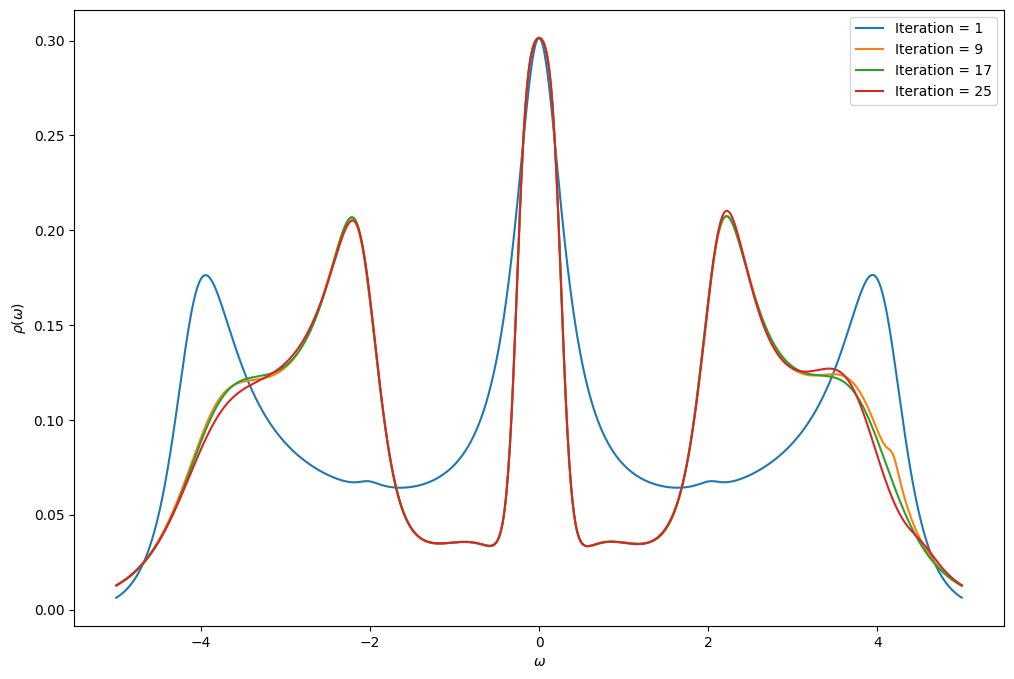

In [2]:
from triqs.plot.mpl_interface import *
%matplotlib inline
# change scale of all figures to make them bigger
import matplotlib as mpl
mpl.rcParams['figure.dpi']=100

t = 1.0
U = 5.0
beta = 20
n_loops = 25

S = IPTSolver(beta = beta)
S.G_iw << SemiCircular(2*t)

fig = plt.figure(figsize=(12,8))

for i in range(n_loops):
    S.G0_iw << inverse( iOmega_n - t**2 * S.G_iw )
    S.solve(U = U)
    
    # Get real axis function with Pade approximation
    G_w = Gf(mesh=MeshReFreq(window = (-5.0,5.0), n_w=1000), target_shape=[1,1])
    G_w.set_from_pade(S.G_iw, 100, 0.01)
    
    if i % 8 == 0:
        oplot(-G_w.imag/pi, figure = fig, label = "Iteration = %i" % (i+1), name=r"$\rho$")

## Visualizing the Mott transition

You now have all the material to do a scan for different values of $U$ and see how a Mott transition appears.

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 3

Write a script which scans values of $U$ between 2.0 and 8.0 and plot the spectral function.
Where does the Mott transition appear?

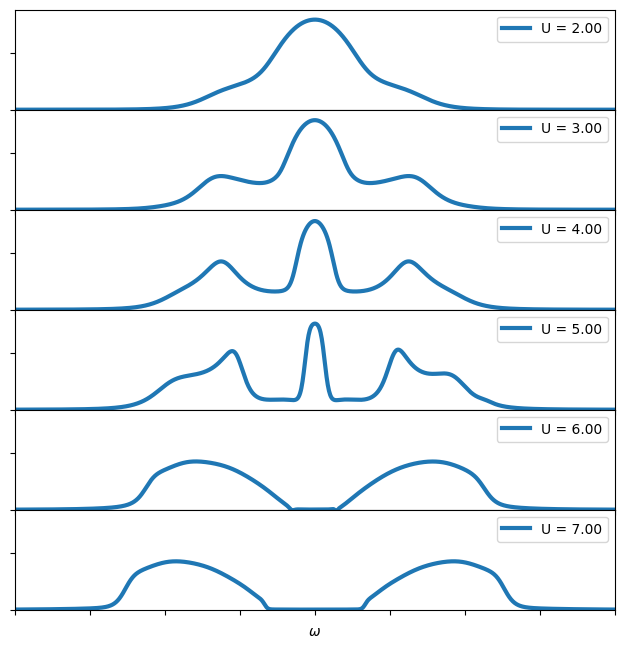

In [3]:
import numpy as np

# Parameters of the model
t = 1.0
beta = 20
n_loops = 25

fig = plt.figure(figsize=(6,6))
pn = 0 # iteration counter for plotting

for U in np.arange(2.0, 7.5, 1.0):
    
    S = IPTSolver(beta = beta)
    S.G_iw << SemiCircular(2*t)

    # DMFT
    for i in range(n_loops):
        S.G0_iw << inverse( iOmega_n - t**2 * S.G_iw )
        S.solve(U)

    # Get the real-axis with Pade approximation
    G_w = Gf(mesh=MeshReFreq(window=(-8.0,8.0), n_w=1000), target_shape=[1,1])
    G_w.set_from_pade(S.G_iw, 100, 0.01)
    
    # plotting
    ax = fig.add_axes([0,1.-(pn+1)/6.,1,1./6.]) # subplot
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    oplot(-G_w.imag/pi, linewidth=3, label = "U = %.2f" % U)
    plt.xlim(-8,8)
    plt.ylim(0,0.35)
    plt.ylabel("")
    pn = pn + 1

## Comparison with the literature

You can compare the result above with what can be found in the literature
(review of Antoine Georges et al.)

<img src="imgs/mott.png" width=30%>